In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from experiments.evaluation.loading import load

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reload = False
folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-11-03/12-29-52/",  # hidden, visible_changing
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-11-03/19-59-39",  # visibile_all, cgate_hadamard, cgate_lstm
]
df = pd.concat([load(folder_eval=folder_eval, rpc_fn=f"tmp/rpc_context_efficiency_{i}.csv", reload_rpc=reload) for i, folder_eval in enumerate(folders_eval)]).reset_index(drop=True)
df = df[df["n_contexts"] < 256]
df["n_contexts_log"] = df["n_contexts"].apply(lambda x: np.log(x)/np.log(2))  # n_contexts are 1,2,4,8,16,... power of 2

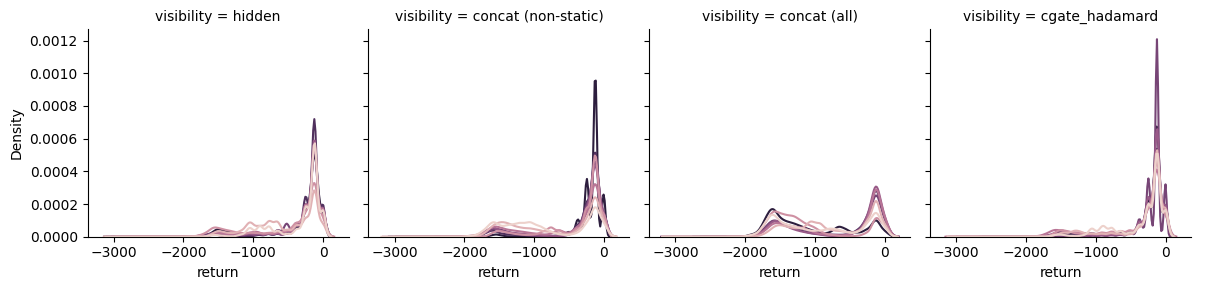

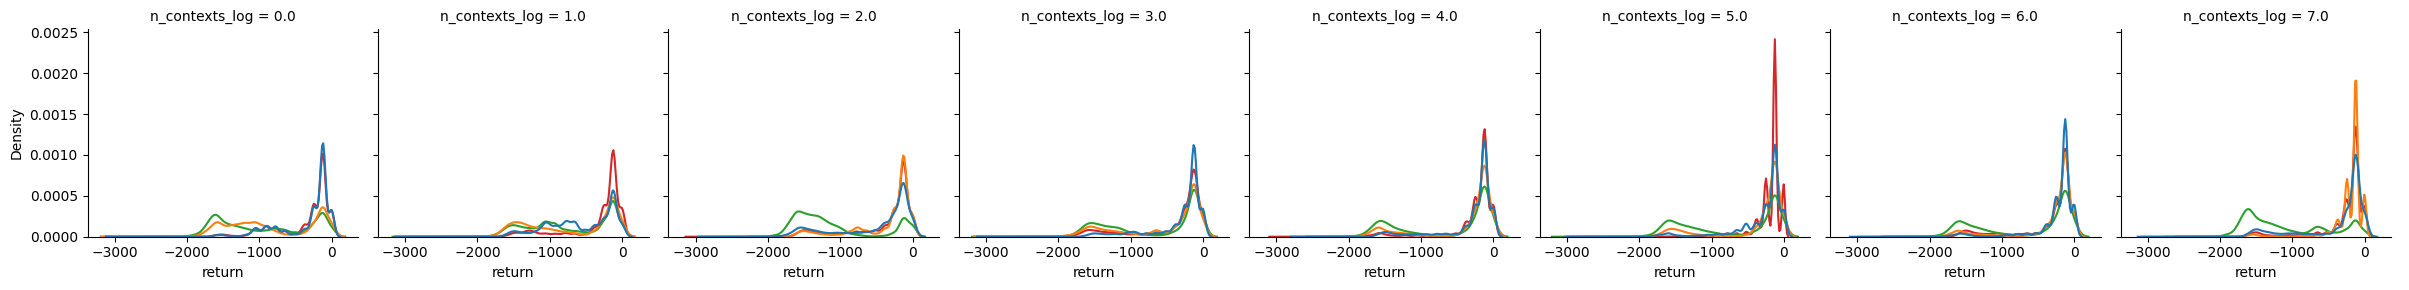

In [3]:

# sns.boxplot(data=df, x="n_contexts", y="return", hue="visibility", showfliers=False)

# filtered_df = df.copy()
# filtered_df = filtered_df[(filtered_df["seed"] != 7) & (filtered_df["seed"] != 8) & (filtered_df["seed"] != 2) & (filtered_df["seed"] != 4)]
# ax = sns.kdeplot(data=filtered_df, x="n_contexts", y="return", hue="visibility", levels=5, cut=0)
# ax = sns.histplot(data=filtered_df, x="n_contexts", y="return", hue="visibility", ax=ax)


col = "visibility"
hue = "n_contexts_log"
grid = sns.FacetGrid(data=df, col=col, legend_out=True)
grid.map_dataframe(sns.kdeplot, x="return", hue=hue)
grid.add_legend()
grid.figure.set_tight_layout(True)
plt.show()

col = "n_contexts_log"
hue = "visibility"
grid = sns.FacetGrid(data=df, col=col, legend_out=True)
grid.map_dataframe(sns.kdeplot, x="return", hue=hue)
grid.add_legend()
grid.figure.set_tight_layout(True)
plt.show()



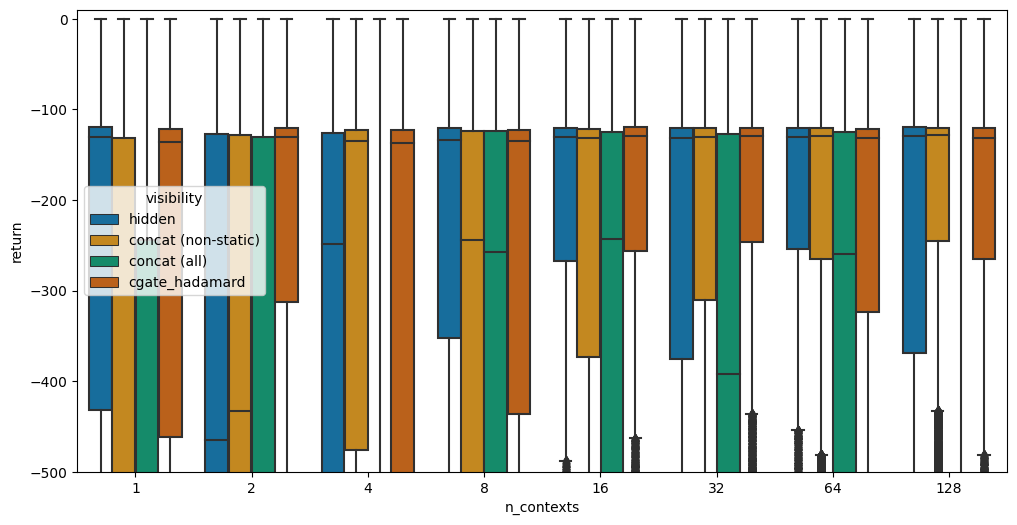

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
# ax = sns.violinplot(data=df, x="n_contexts", y="return", hue="visibility", cut=0, ax=ax)
# ax = sns.lineplot(data=df, x="n_contexts", y="return", hue="visibility", ax=ax)
ax = sns.boxplot(data=df, x="n_contexts", y="return", hue="visibility", ax=ax)
ax.set_ylim(-500, 10)
plt.show()